# Predicting JunD binding

In [9]:
#!pip install rpy2
#!pip install tzlocal
#!conda install --yes -c bioconda bedtools samtools 

In [10]:
import os
%load_ext rpy2.ipython

from IPython.display import Image

In [5]:
datadir = '../data'
outputdir = '../jund_results'

Run a grid search for a DNA only model.
(Since the following parts are rather time consuming, they will be reran only if you remove the hashtags).

In [ ]:
#!python dna_only.py -inputpath {datadir} -path {outputdir}

Run a grid search on a DNase only model

In [ ]:
#!python dnase_only.py -inputpath {datadir} -path {outputdir}

Fit models that use DNA and DNase as input simultaneously

In [ ]:
#!python dnase_dna_use_pretrained.py -inputpath {datadir} -path {outputdir}

Illustrate an example genomic locus

Input, ground truth and predictions

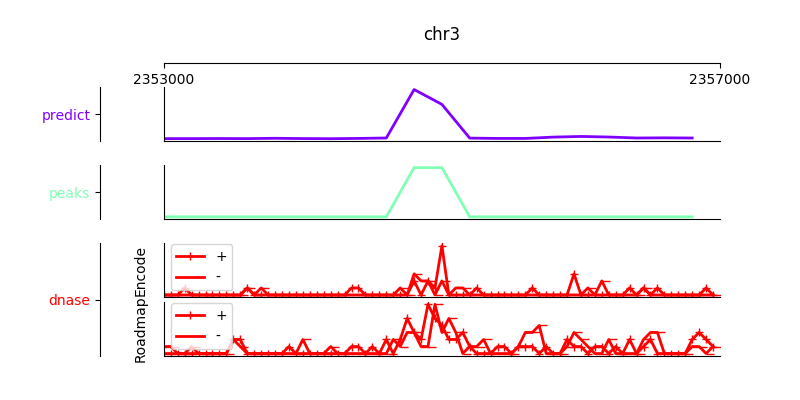

In [7]:
Image(os.path.join(outputdir, 'jund_input_outout_line.png'))

Illustration of input feature importance discovered by integrated gradients

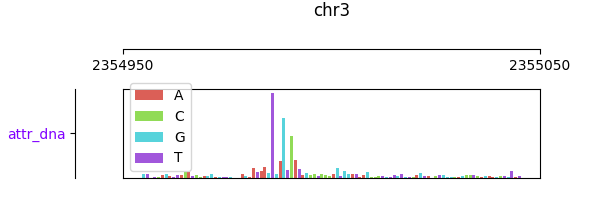

In [8]:
Image(os.path.join(outputdir, 'jund_input_attribution_dna.png'))

The following figures illustrate the performances obtained from the grid search runs.

In [12]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [13]:
results = os.path.join(outputdir, 'dna_gridsearch_5.tsv')

  Group.1 Group.2         x
1     0,0       1 0,3667163
2     0,2       1 0,3317765
3     0,0       2 0,4499069
4     0,2       2 0,4410833
5     0,0       3 0,4594120
6     0,2       3 0,4742865


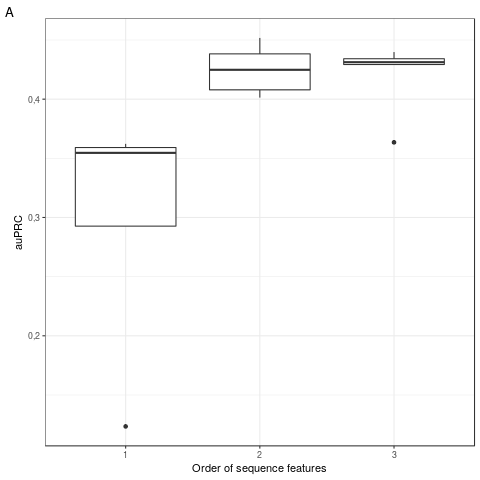

In [18]:
%%R -i results

dna = read.table(results)
print(aggregate(dna[,2], list(dna[,3], dna[,4]), median))

g1 = ggplot(subset(dna, dropout==0.0), aes(x=as.factor(order), y=auprc_val)) + geom_boxplot() + xlab("Order of sequence features") + ylab("auPRC") + theme_bw() +labs(tag="A")
print(g1)

In [16]:
figure = os.path.join(outputdir, 'dna_gridsearch.png')

%R -i figure ggsave(figure, height=4, width=3)

In [19]:
figure = os.path.join(outputdir, 'dna_gridsearch_drop.png')

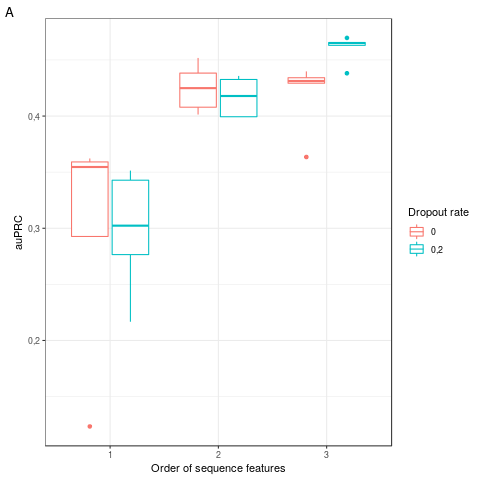

In [21]:
%%R -i figure
g1 = ggplot(dna, aes(x=as.factor(order), y=auprc_val, color=as.factor(dropout))) + 
   geom_boxplot() + xlab("Order of sequence features") + 
    ylab("auPRC") + guides(color=guide_legend(title="Dropout rate")) + 
    theme_bw() + labs(tag="A")
print(g1)
ggsave(figure, height=4, width=3)


In [22]:
dnaseresults = os.path.join(outputdir, "dnase_gridsearch_7.tsv")

In [23]:
%%R -i dnaseresults

dnase = read.table(dnaseresults, stringsAsFactors = F)
dnase$augment[dnase$augment=="orient"] = "Flip orientation"
dnase$augment[dnase$augment=="none"] = "None"
dnase$normalize[dnase$normalize=="tpm"] = "TPM"
dnase$normalize[dnase$normalize=="none"] = "None"
dnase$normalize[dnase$normalize=="zscorelog"] = "Z-score of log-counts"



In [ ]:
figure = os.path.join(outputdir, "/dnase_gridsearch.png")

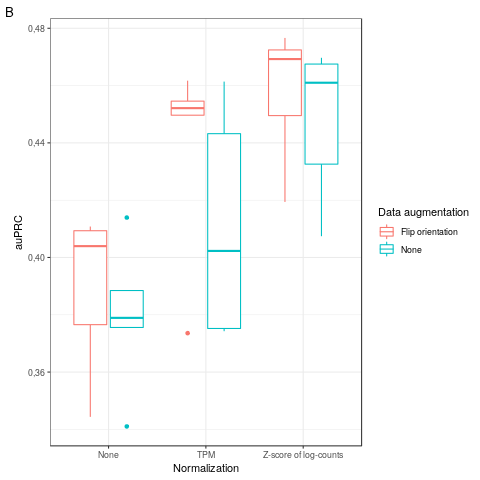

In [29]:
%%R -i figure
g2=ggplot(subset(dnase, normalize!="zscore"), aes(x=normalize, y=auprc_test, color=augment)) + 
 geom_boxplot() + xlab("Normalization") + 
  ylab("auPRC") + 
  guides(color=guide_legend(title="Data augmentation")) + theme_bw() +   labs(tag="B")
print(g2)
ggsave(figure, height=4, width=6)


In [30]:
pretres =  os.path.join(outputdir, "dnase_dna_use_pretrained_submodels.tsv")
randres =  os.path.join(outputdir, "dnase_dna_use_randominit_submodels.tsv")

In [31]:
%R -i pretres pret = read.table(pretres, stringsAsFactors = F)
%R -i randres randini = read.table(randres, stringsAsFactors = F)

,auprc_val,auprc_test
0,0.651323,0.657306
1,0.612231,0.626950
2,0.669799,0.682610
3,0.678249,0.679717
4,0.615023,0.615330


In [ ]:
figure =  os.path.join(outputdir, "dna_dnase_joint.png")

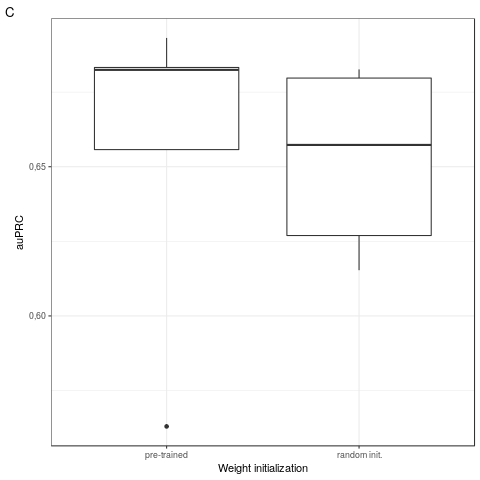

In [35]:
%%R -i figure
pret$init = "pre-trained"
randini$init = "random init."

df <- rbind(pret, randini)
g3 <- ggplot(df, aes(x=init, y=auprc_test)) + geom_boxplot() +  xlab("Weight initialization") + ylab("auPRC") + theme_bw() + labs(tag="C")

print(g3)
ggsave(figure, height=4, width=3)